In [226]:
import numpy as np
import matplotlib.pyplot as plt
from monte_carlo import samples, utils
from tqdm.notebook import trange, tqdm
import xarray as xr

In [554]:
# Wind Setup 
ref_height = 100      # power law reference height 
shear_exponent = 0.2  # power law shear exponent
wind_speed = 10       # wind speed at referenc height

# Base setup of LOS direction
dis = 1000        # meters
angular_res = 1   # degrees
azimuth_mid = 0   # central azimuth angle

# Uncertainty terms
mu = 0 # we assume there is no bias
azim_std = 0.1 # degrees
elev_std = 0.1 # degrees
dis_std = 10   # meters
rad_std = 0.1  # m.s-1


# Setup loops
no_sim = 100
corr_coefs = np.arange(0, 1 + 0.1, 0.1)
wind_dirs = np.arange(0, 360 + 5, 5)
sectors = np.arange(10, 90 + 5, 5)

# Setup results matrix
uncert = np.full((len(corr_coefs), 
                       len(wind_dirs), 
                       len(sectors),2), np.nan)


for i,corr_coef in enumerate(tqdm(corr_coefs, desc ="Correletation loop")):
    
    for j,wind_dir in enumerate(tqdm(wind_dirs, desc = "Wind direction loop", leave = False)):
        w = 0
        u = - wind_speed * np.sin(np.radians(wind_dir))
        v = - wind_speed * np.cos(np.radians(wind_dir))
        
        for k,sector in enumerate(tqdm(sectors, desc = "Sector size loop", leave = False)):
            azimuth = np.arange(azimuth_mid-sector/2, 
                                 azimuth_mid+sector/2 + angular_res, angular_res, dtype=float)
            distance = np.full(len(azimuth), dis)
            elevation = np.full(len(azimuth), np.degrees(np.arcsin(ref_height / dis)))

            # Generate uncertainties
            u_azim = samples.gen_correlated_samples(np.full(len(azimuth), mu), 
                                                    np.full(len(azimuth), azim_std), 
                                                    corr_coef, no_sim)
            u_elev = samples.gen_correlated_samples(np.full(len(elevation), mu), 
                                                    np.full(len(elevation), elev_std), 
                                                    corr_coef, no_sim)
            u_dist = samples.gen_correlated_samples(np.full(len(distance), mu), 
                                                    np.full(len(distance), dis_std), 
                                                    corr_coef, no_sim)
            u_est = samples.gen_correlated_samples(np.full(len(distance), mu), 
                                                   np.full(len(distance), rad_std), 
                                                   corr_coef, no_sim)

            # Setup reconstruction matrices
            wind_speed_rc = u_rc = v_rc = np.full(no_sim, np.nan)
            
            for l in range(0, no_sim):
                # Adding uncertainties to the beam
                # positioning coordinates
                azi_new = azimuth + u_azim[l] 
                elev_new =  elevation + u_elev[l]
                dis_new = distance + u_dist[l]
                
                # Calculating the actual measurement height 
                # and the corresponding wind conditions
                # assuming power law 
                height_meas = np.sin(np.radians(elev_new)) * dis_new
                gain = (height_meas / ref_height)**shear_exponent
                u_new = gain * u
                v_new = gain * v
                w_new = np.full(len(u_new), w)
                los = utils.wind_vector_to_los(u_new, v_new, w_new, azi_new, elev_new) 
                
                # Adding radial velocity estimation uncertainty
                # to the project wind vector on the LOS
                tmp = np.copy(los)
                los += u_est[l]

                # Retrieving u, v, and wind_speed by applying
                # IVAP algorithm on the LOS speed
                u_rc[l], v_rc[l], wind_speed_rc[l] = utils.ivap(los, azimuth)
            
            uncert[i,j,k,0] = wind_speed_rc.mean()
            uncert[i,j,k,1] = wind_speed_rc.std()
            

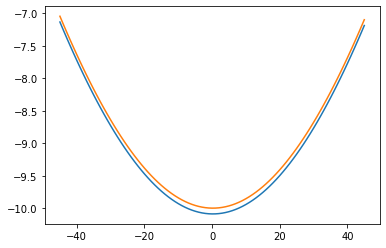

In [559]:
#plt.plot(azimuth, np.round(u_est[-1],2))
plt.plot(azimuth, los)
plt.plot(azimuth, tmp)

In [542]:
ds = xr.Dataset({'wind_speed': (['correlation_coefficient', 'wind_direction','sector_size'],  uncert[:, : ,:, 0]),
                 'u_ws': (['correlation_coefficient', 'wind_direction','sector_size'],  uncert[:, : ,:, 1])},
                coords={'correlation_coefficient': corr_coefs,
                        'wind_direction': wind_dirs,
                        'sector_size': sectors})


ds = ds.transpose('correlation_coefficient', 'sector_size', 'wind_direction')
ds.wind_speed.attrs['units'] = 'm.s-1'
ds.u_ws.attrs['units'] = 'm.s-1'
ds.wind_direction.attrs['units'] = 'degree'
ds.sector_size.attrs['units'] = 'degree'
ds.correlation_coefficient.attrs['units'] = 'factor'


# ds.to_netcdf('./mc-results-sector-scan-1000m.nc')

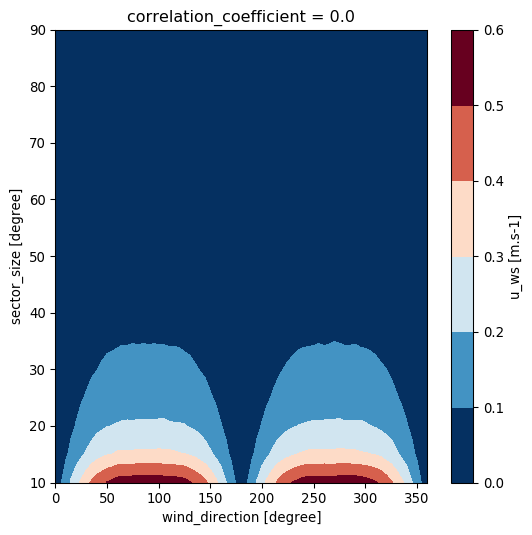

In [431]:

width_px = height_px = 600 # resolution of plots
MY_DPI = 96
fig, axes = plt.subplots(figsize=(width_px/MY_DPI, height_px/MY_DPI), dpi=MY_DPI)

ds.u_ws.isel(correlation_coefficient = 0).plot.contourf(cmap = plt.cm.RdBu_r)

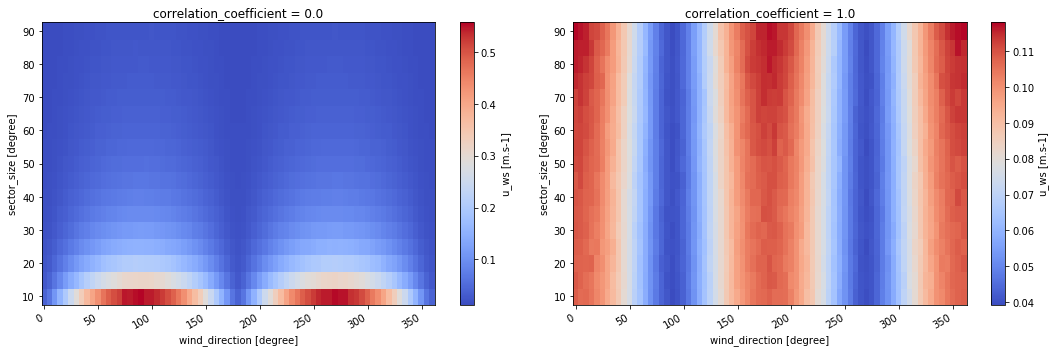

In [536]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax1, ax2 = axes.flat

(ds.u_ws.sel(correlation_coefficient = 0)
        .plot(ax=ax1, cmap='coolwarm'))


(ds.u_ws.sel(correlation_coefficient = 1)
        .plot(ax=ax2, cmap='coolwarm'))

for ax in axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')


fig.tight_layout()  

fig.savefig('./plots/all_sectors_1000m.png')

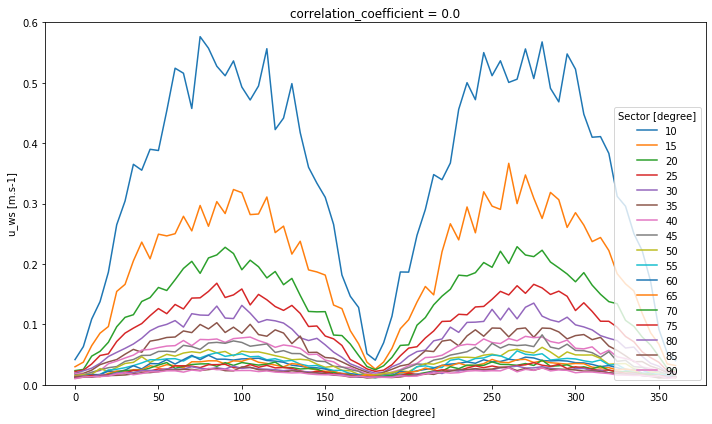

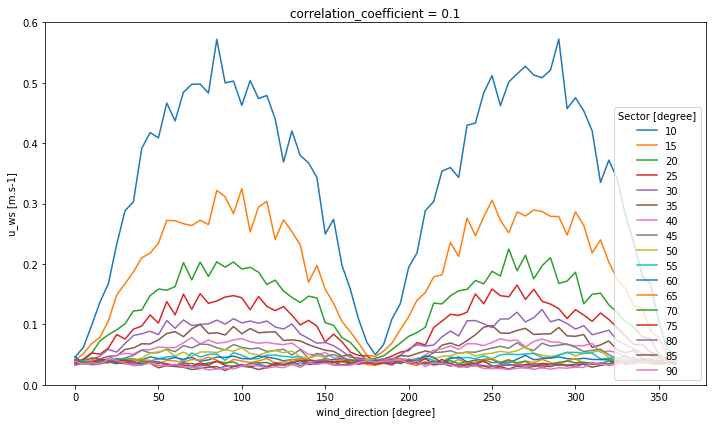

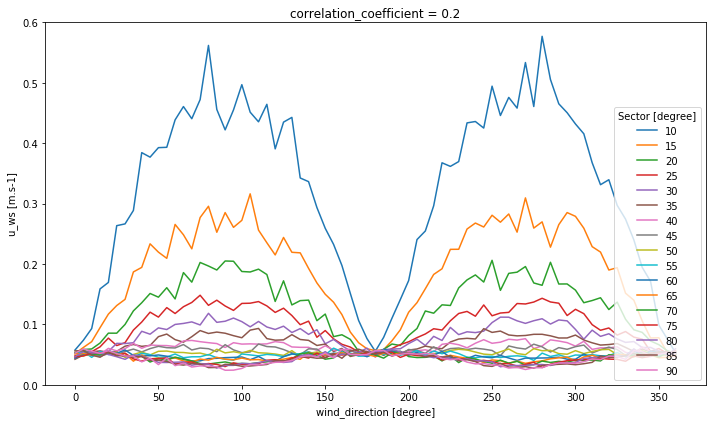

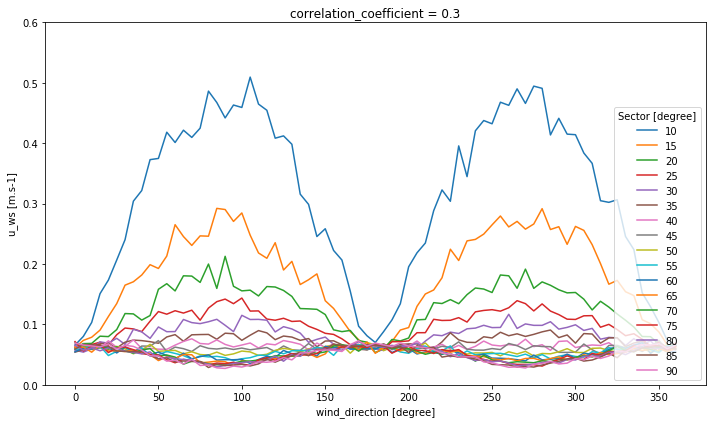

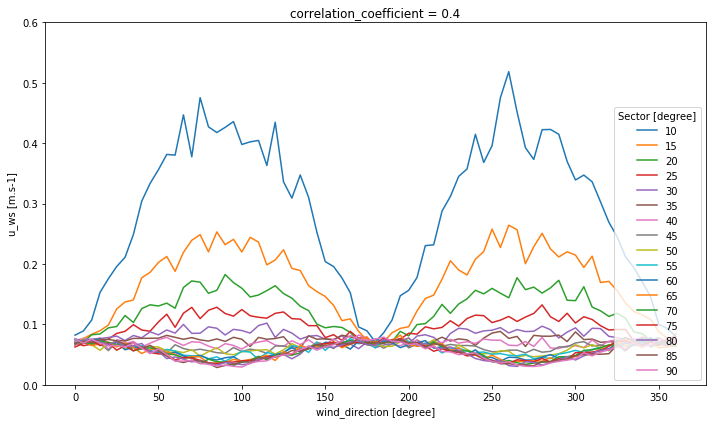

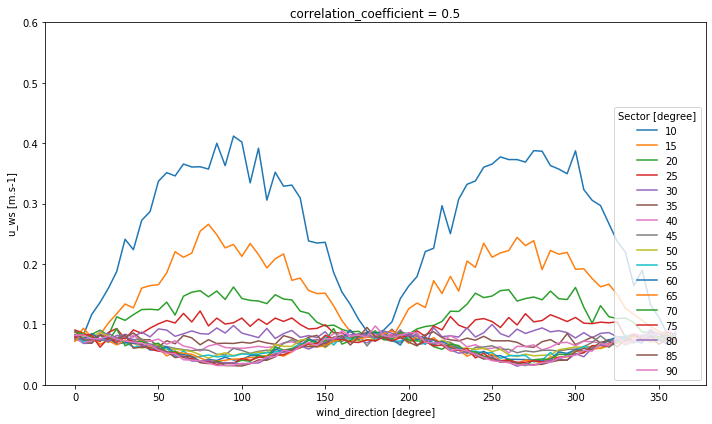

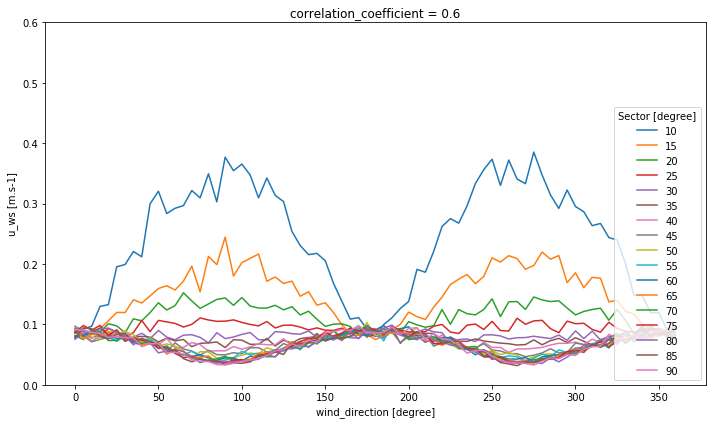

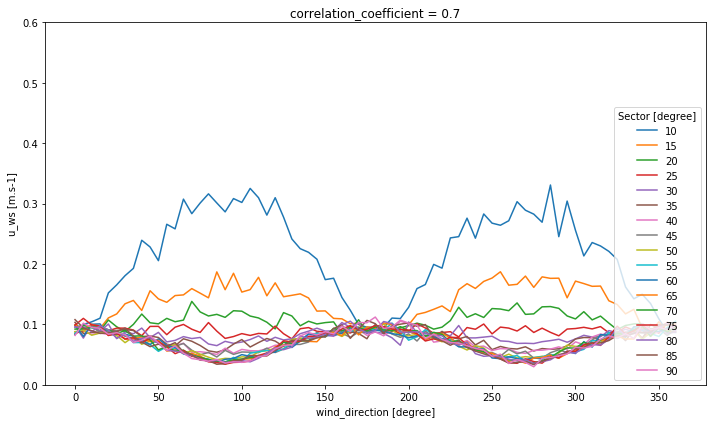

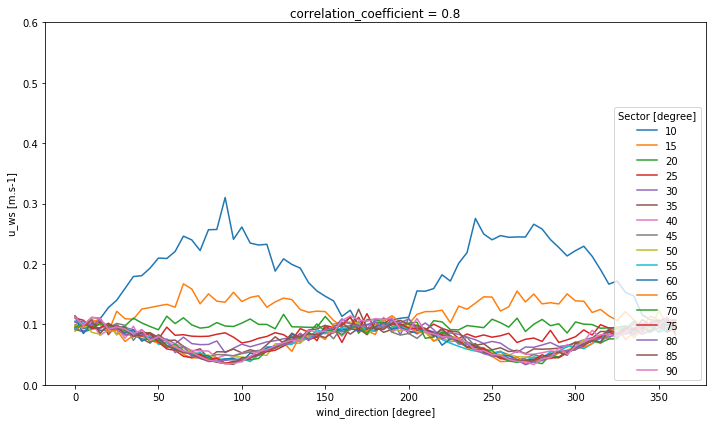

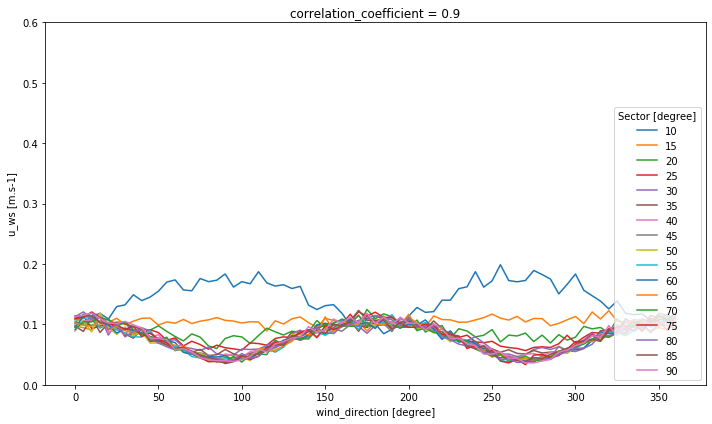

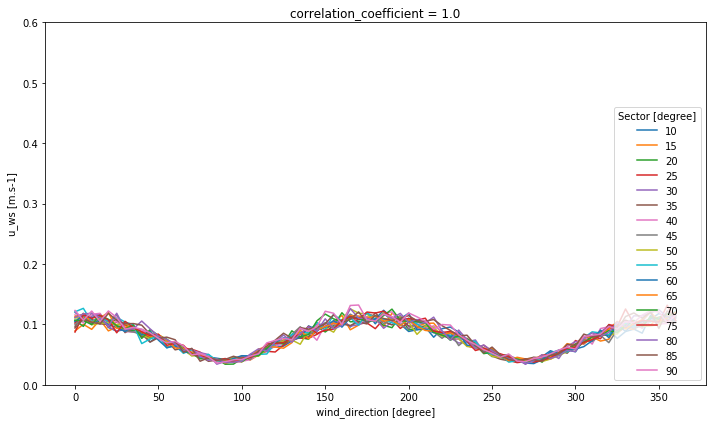

In [543]:
for i, cor_coef in enumerate(ds.correlation_coefficient.values):
    fig, ax = plt.subplots(figsize=(10, 6))


    for s_size in sectors:

        ds.u_ws.sel(correlation_coefficient = cor_coef, sector_size = s_size).plot(label = str(s_size))
        


    plt.ylim(0, 0.6)
    ax.set_title('correlation_coefficient = ' + str(round(cor_coef,2)) )
    ax.legend(loc='lower right', fontsize=10, title='Sector [degree]') 
    
    fig.tight_layout()  

#    fig.savefig('./plots/' + str(i)+ '_cor_coef_1000m.png')